#  Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+

**Цель исследования:** необходимо выявить причины, почему последние несколько месяцев компания, развлекательного приложения Procrastinate Pro+, терпит убыткии, несмотря на огромные вложения в рекламу. 

**Входные данные:** данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.

**План работы:** 1. изучить общую информацию о предоставленных данных; 2. подготовить данные, т.е. выявить и удалить (заменить) пропущенные значения и дубликаты, изменить тип данных при необходимости; 3. провести исследовательский анализ данных; 4. повести маркетинговое исследование; 5. оценить окупаемость рекламы.

Данное исследование позволит разобраться в причинах и помочь компании выйти в плюс.

### Загрузка данных и подготовка их к анализу

In [1]:
# Загрузим библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# чтение файлов с данными и сохранение в переменные
try: visits, orders, costs = (
 pd.read_csv('/datasets/visits_info_short.csv'),
 pd.read_csv('/datasets/orders_info_short.csv'),
 pd.read_csv('/datasets/costs_info_short.csv'), 
)
except: visits, orders, costs = (
 pd.read_csv('C:/Users/user/Downloads/visits_info_short.csv'), 
 pd.read_csv('C:/Users/user/Downloads/orders_info_short.csv'), 
 pd.read_csv('C:/Users/user/Downloads/costs_info_short.csv'), 
)   

In [3]:
#Изучим данные и выполним предобработку.
for row in [visits, orders, costs]:
 display(row.head())
 display(row.info())
 print('Количество дубликатов:', row.duplicated().sum())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

Количество дубликатов: 0


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

Количество дубликатов: 0


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Количество дубликатов: 0


**Вывод:**

Пропусков и дубликатов в данных нет, названия столбцов изменим, чтобы соответствовали snake case.

In [4]:
for i in [visits, orders, costs]:
    i.columns = [x.lower().replace(' ', '_') for x in i.columns.values] 

In [5]:
#Преобразуем данные о времени в столбцах всех таблиц
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**Вывод:**

Данные к анализу подготовлены.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

**Функция для создания профилей пользователей**

In [6]:
def get_profiles(sessions, orders, costs):
    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg(
                    {
                        'session_start' : 'first',
                        'channel' : 'first',
                        'device' : 'first',
                        'region' : 'first'
                    }
                )
                .rename(columns={'session_start' : 'first_ts'})
                .reset_index()
               )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак пользователей, совершивших покупку
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

 **Функция для подсчёта Retention Rate**

In [7]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw  = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта конверсии**

In [8]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для расчета LTV и ROI**

In [9]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функция для сглаживания данных**

In [10]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция для построения графика Retention Rate**

In [11]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция для построения графика конверсии**

In [12]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для визуализации LTV и ROI**

In [13]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод:**

Необходимые функции загружены.

### Проведем исследовательский анализ данных

In [14]:
#Составляем профили пользователей. 
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [15]:
#Определяем минимальную и максимальную даты привлечения пользователей.
display(f'Минимальная дата привлечения пользователей {profiles.first_ts.min()}, максимальная {profiles.first_ts.max()}')

'Минимальная дата привлечения пользователей 2019-05-01 00:00:41, максимальная 2019-10-27 23:59:04'

**Вывод:**

В таблице данные с 1 мая 2019 года по 27 октября 2019 года. Возьмем горизонт анализа 2 недели, а за момент анализа - 1 ноября 2019г.

In [16]:
observation_date = datetime(2019, 11, 1).date()#момент анализа
horizon_days = 14 #горизонт анализа

In [17]:
#Выясняем, из каких стран пользователи приходят в приложение.
display(profiles.region.unique())

array(['United States', 'France', 'Germany', 'UK'], dtype=object)

In [18]:
#Узнаем на какую страну приходится больше всего платящих пользователей.
#Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
region_users = (
    profiles.groupby('region')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('region')['user_id'].nunique().reset_index(), 
           on = 'region', how = 'left')
)
region_users.set_axis(['region', 'total_users', 'payers'], axis='columns', inplace=True)
region_users['payer_rate'] = region_users.payers / region_users.total_users *100
display(region_users.sort_values(by='payer_rate', ascending=False))

,region,total_users,payers,payer_rate
3,United States,100002,6902,6.901862
1,Germany,14981,616,4.111875
2,UK,17575,700,3.982930
0,France,17450,663,3.799427


**Вывод:**

Как видим, пользователи приложения из стран: США, Германия, Англия и Франция. По всем позициям лидирует США: общее количество пользователей, количество платящих пользователей, доля платящих пользователей по отношению к общему количеству пользователей.

In [19]:
#Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
print(profiles.device.unique())
device_users = (
    profiles.groupby('device')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('device')['user_id'].nunique().reset_index(), on = 'device', how = 'left')
)
device_users.set_axis(['device', 'total_users', 'payers'], axis='columns', inplace=True)
device_users['payer_rate'] = device_users.payers / device_users.total_users *100
device_users.sort_values(by='payer_rate', ascending=False)

['Mac' 'iPhone' 'PC' 'Android']


,device,total_users,payers,payer_rate
1,Mac,30042,1912,6.364423
3,iPhone,54479,3382,6.207897
0,Android,35032,2050,5.851793
2,PC,30455,1537,5.046790


**Вывод:**

По общему количеству пользователей и количеству платящих пользователей, лидирует iPhone. А вот доля платящих выше у Mac, хоть и не значительно.

In [20]:
#Изучим рекламные источники привлечения. 
profiles.channel.unique()

array(['FaceBoom', 'organic', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [21]:
#Определим каналы, из которых пришло больше всего платящих пользователей.
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.
channel_users = (
    profiles.groupby('channel')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('channel')['user_id'].nunique().reset_index(), on = 'channel', how = 'left')
)
channel_users.set_axis(['channel', 'total_users', 'payers'], axis='columns', inplace=True)
channel_users['payer_rate'] = channel_users.payers / channel_users.total_users *100
channel_users.sort_values(by='payer_rate', ascending=False)

,channel,total_users,payers,payer_rate
1,FaceBoom,29144,3557,12.204914
0,AdNonSense,3880,440,11.340206
9,lambdaMediaAds,2149,225,10.469986
6,TipTop,19561,1878,9.600736
5,RocketSuperAds,4448,352,7.913669
7,WahooNetBanner,8553,453,5.296387
8,YRabbit,4312,165,3.826531
3,MediaTornado,4364,156,3.574702
2,LeapBob,8553,262,3.063253
4,OppleCreativeMedia,8605,233,2.707728


**Вывод:**

- В данных информация о пользователях из четырех стран: США, Франции, Германии и Англия. 
- Больше всего общее количество пользователей, количество платящих пользователей и доля платящих пользователей в США. Доли платящих пользователей, в других странах, не сильно отличаются друг от друга.
- Клиенты пользуются 4 видами устройств: Mac, PC, iPhone и Android. Больше всего пользователей предпочитают iPhone, доля платящих пользователей больше с устройством Mac.  
- Рекламных каналов 11 шт., лидирует по общему количеству пользователей: organic, FaceBoom и TipTop, по количеству платящих пользователей FaceBoom, TipTop, organic, а вот по доле платящих organic уже на последнем месте, лидирует FaceBoom, AdNonSense, lambdaMediaAds.	

### Маркетинг

In [22]:
#Посчитаем общую сумму расходов на маркетинг.
costs_sum = costs.costs.sum()
display(costs_sum)

105497.30000000002

In [23]:
#Выясним сколько денег потратили на каждый источник.
costs_per = (costs.pivot_table(index='channel', values='costs', aggfunc='sum')
    .sort_values(ascending=False, by='costs')
)
costs_per['costs_percent'] = costs_per.costs / costs_sum *100
costs_per

,costs,costs_percent
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


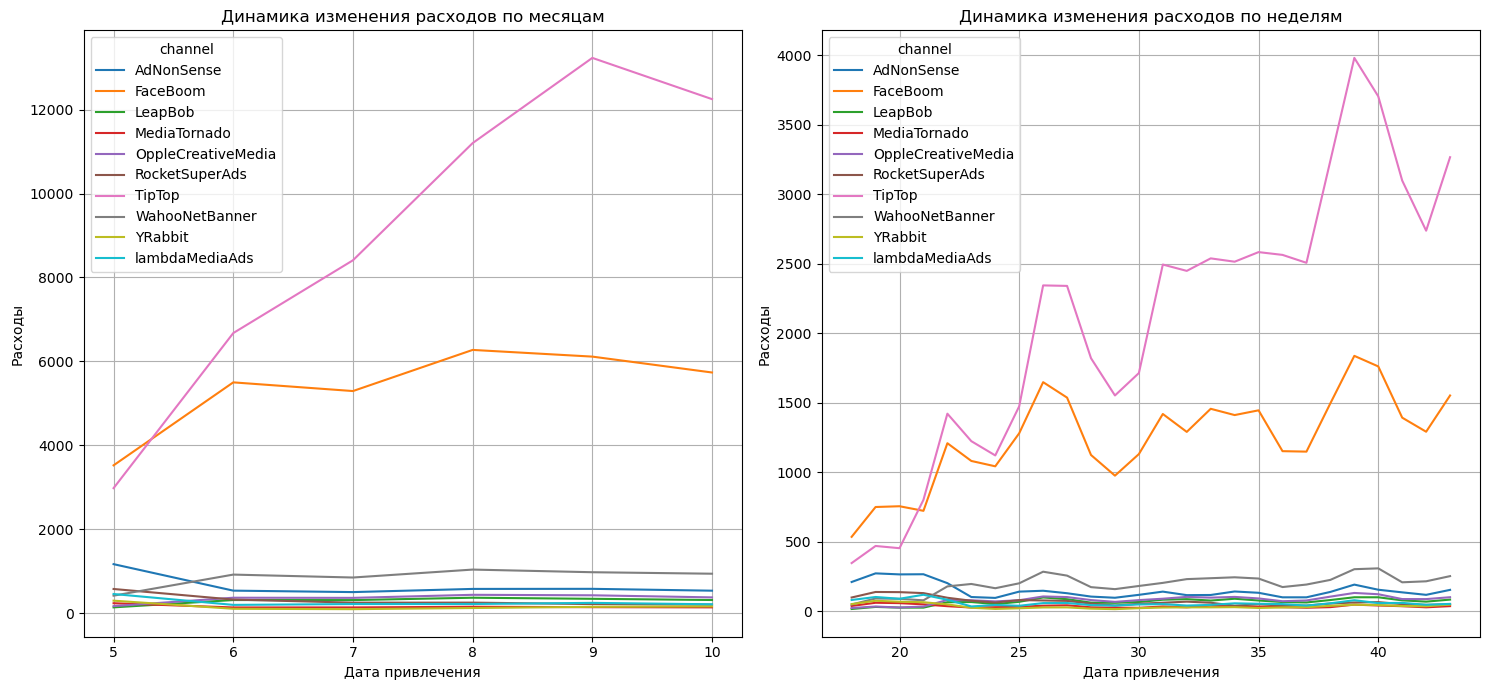

In [24]:
#Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, figsize=(15, 7), ax=ax1)
plt.ylabel('Расходы')
plt.xlabel('Дата привлечения')
plt.title('Динамика изменения расходов по месяцам')

ax2 = plt.subplot(1, 2, 2)
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, figsize=(15, 7), ax=ax2)
plt.ylabel('Расходы')
plt.xlabel('Дата привлечения')
plt.title('Динамика изменения расходов по неделям')

plt.tight_layout()
plt.show()

**Вывод:**

Больше всего потратили денег на источники: TipTop 54751.30 и FaceBoom 32445.60. На остальные источники потратили меньше 6000.

In [25]:
# Исключим из дальнейшего анализа самые затратные каналы "TipTop" и "FaceBoom"
costs_no = costs.query('channel != "TipTop" and channel != "FaceBoom"').copy()

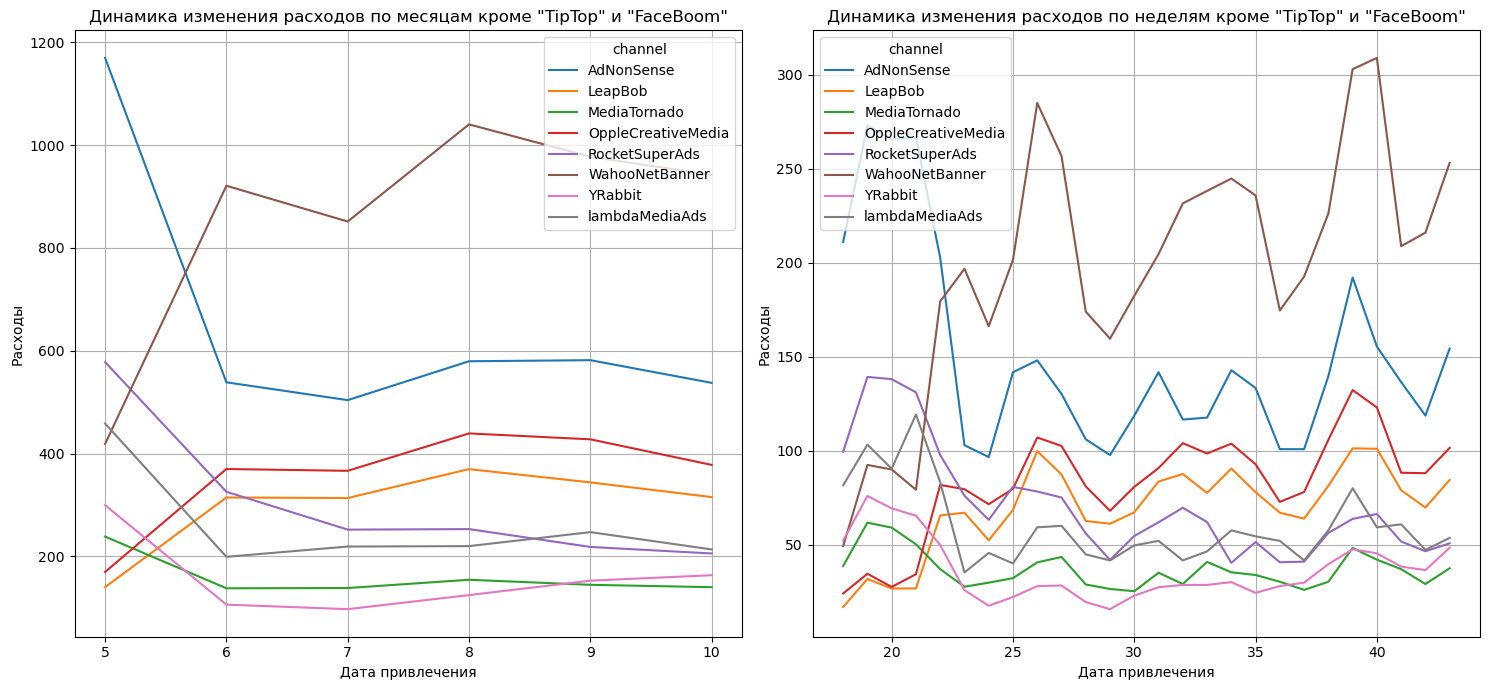

In [26]:
#Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику кроме "TipTop" и "FaceBoom". 
costs_no['month'] = pd.to_datetime(costs['dt']).dt.month
costs_no['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

ax1 = plt.subplot(1, 2, 1)
costs_no.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, figsize=(15, 7), ax=ax1)
plt.ylabel('Расходы')
plt.xlabel('Дата привлечения')
plt.title('Динамика изменения расходов по месяцам кроме "TipTop" и "FaceBoom"')

ax2 = plt.subplot(1, 2, 2)
costs_no.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, figsize=(15, 7), ax=ax2)
plt.ylabel('Расходы')
plt.xlabel('Дата привлечения')
plt.title('Динамика изменения расходов по неделям кроме "TipTop" и "FaceBoom"')

plt.tight_layout()
plt.show()

**Вывод:**

После удаления из графиков каналов "TipTop" и "FaceBoom", стали видны особенности двух каналов: расходы для канала WahooNetBanner с февраля месяца только увеличиваются, хоть и скачкообразно, можно предположить, что этот канал становиться популярным, ведь на нем расходы на рекламу окупаются; расходы для канала AdNonSense взлетели в апреле, в июне резко упали, до октября включительно практически идут на одном уровне, видимо была большая рекламная кампания.

In [27]:
#Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 
ad_costs = channel_users.merge(costs.groupby('channel')['costs'].sum().reset_index(), on = 'channel', how = 'left')
ad_costs = ad_costs.query('channel != "organic"')

ad_costs['cac_costs'] = ad_costs.costs / ad_costs.total_users
ad_costs.sort_values(by='cac_costs', ascending=False)

,channel,total_users,payers,payer_rate,costs,cac_costs
6,TipTop,19561,1878,9.600736,54751.30,2.799003
1,FaceBoom,29144,3557,12.204914,32445.60,1.113286
0,AdNonSense,3880,440,11.340206,3911.25,1.008054
9,lambdaMediaAds,2149,225,10.469986,1557.60,0.724802
7,WahooNetBanner,8553,453,5.296387,5151.00,0.602245
5,RocketSuperAds,4448,352,7.913669,1833.00,0.412095
4,OppleCreativeMedia,8605,233,2.707728,2151.25,0.250000
8,YRabbit,4312,165,3.826531,944.22,0.218975
3,MediaTornado,4364,156,3.574702,954.48,0.218717
2,LeapBob,8553,262,3.063253,1797.60,0.210172


In [28]:
cac_mean = ad_costs.cac_costs.mean()
print('Среднее CAC по всем каналам:', cac_mean)

Среднее CAC по всем каналам: 0.7557348976115398


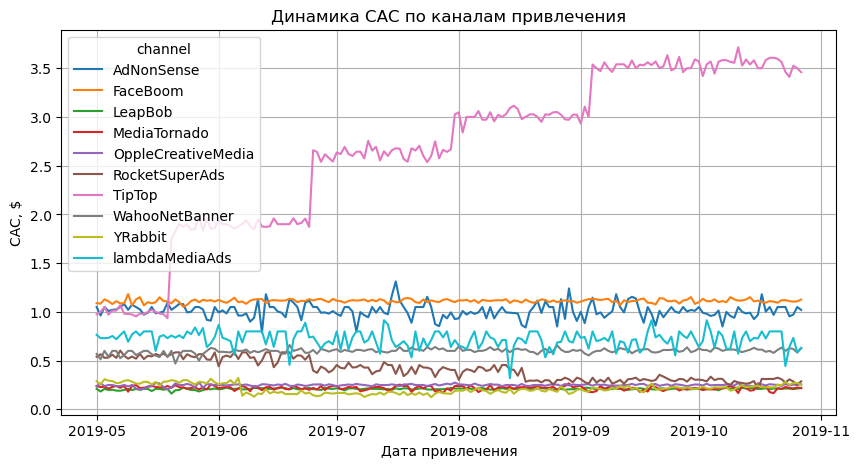

In [29]:
# Построим график динамики САС для всех кналов кроме "organic"
profiles1 = profiles.query('channel != "organic"')
profiles1.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

**Вывод:**

- Общую сумма расходов на маркетинг составила 105497.30.
- Больше половины этой суммы досталось источнику TipTop - 54751.30, что и не удивительно, средняя "стоимость" клиента на этом канале 2,7. На втором месте FaceBoom - 32445.60, но и затраты на рекламу у этого канала почти в 3 раза ниже, чем у лидера.
- Среднее САС равно 0,75, у всех каналов, кроме TipTop, FaceBoom, AdNonSense ниже среднего. К тому же у TipTop постоянно растет.

### Оцените окупаемость рекламы

In [30]:
# Отфильтровали органику
profiles_no_organic= profiles.query('channel != "organic"')

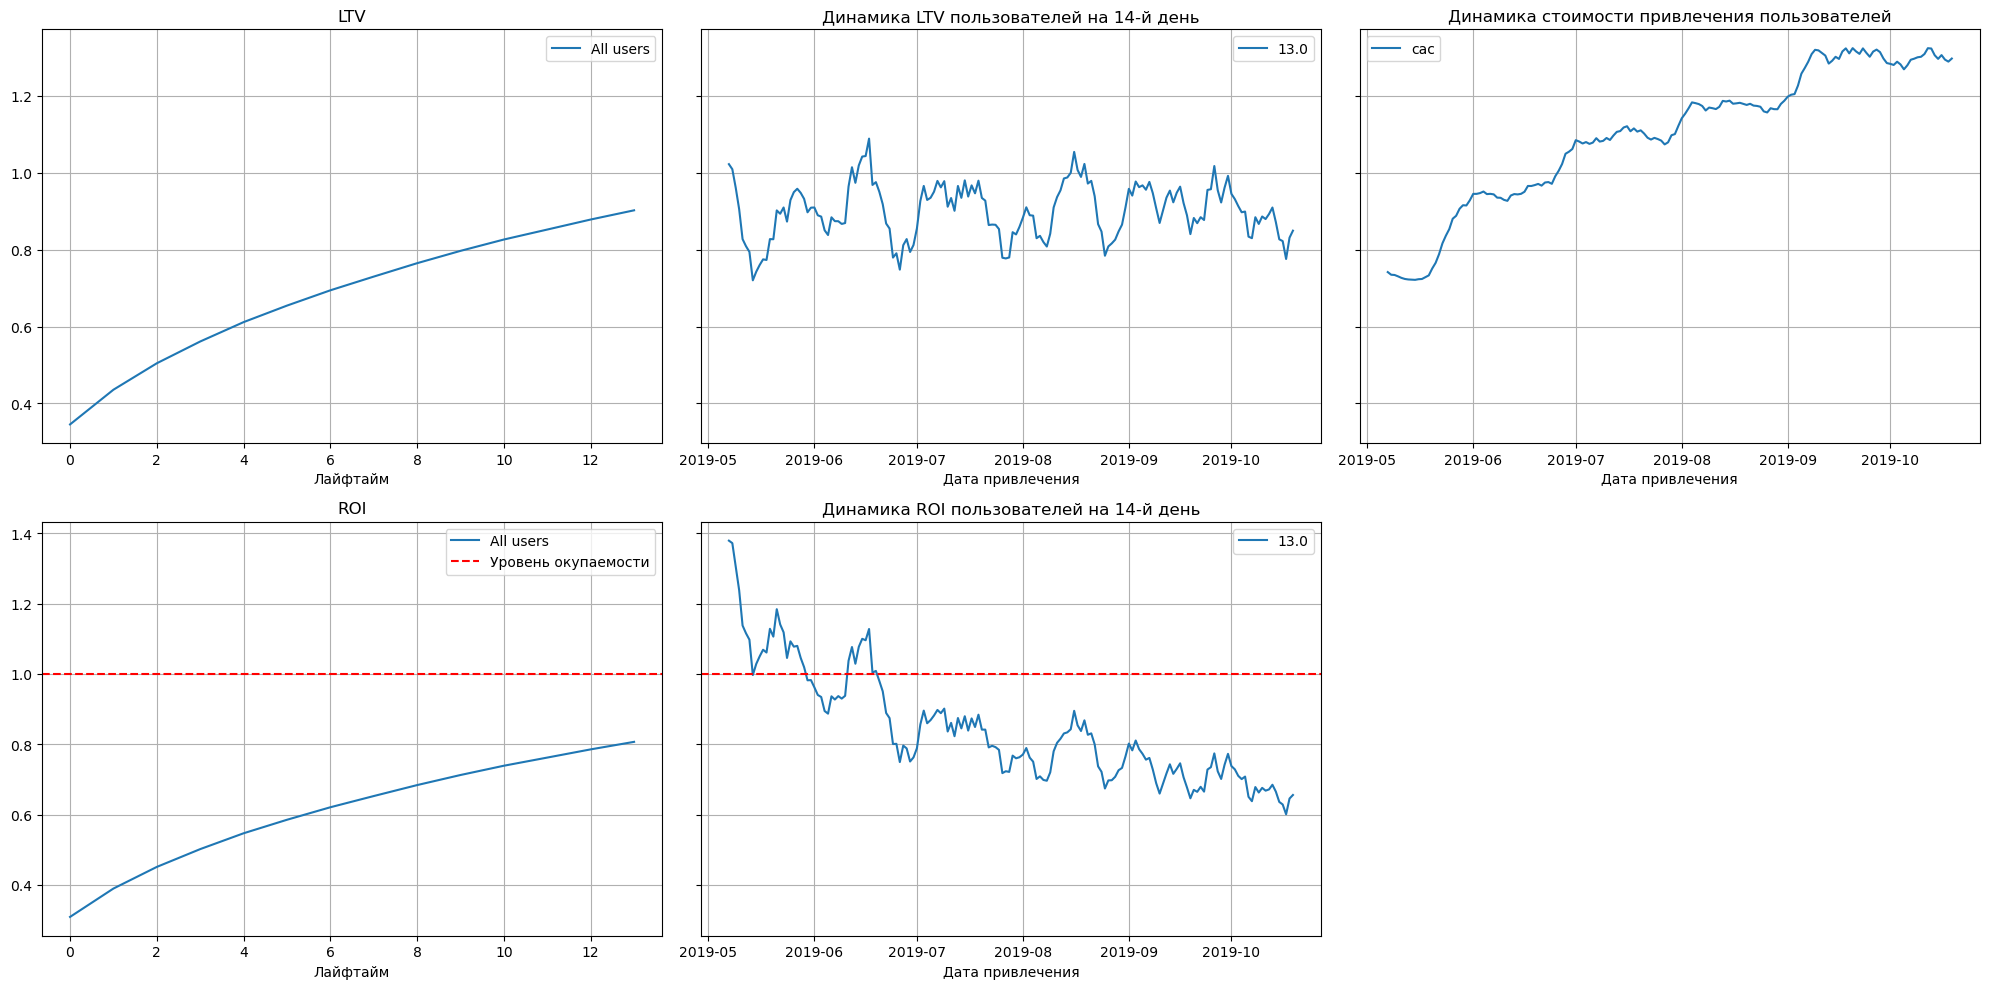

In [31]:
#Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_no_organic, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:**

По графикам можно сделать такие выводы:
- Реклама не окупается. К концу двух недель ROI на уровне 80%
- CAC растет почти все время, причем не плавно, а скачкообразно, то есть рекламные кампании проходят регулярно
- LTV стабилен. Значит, пользователи примерно одинакового качества.

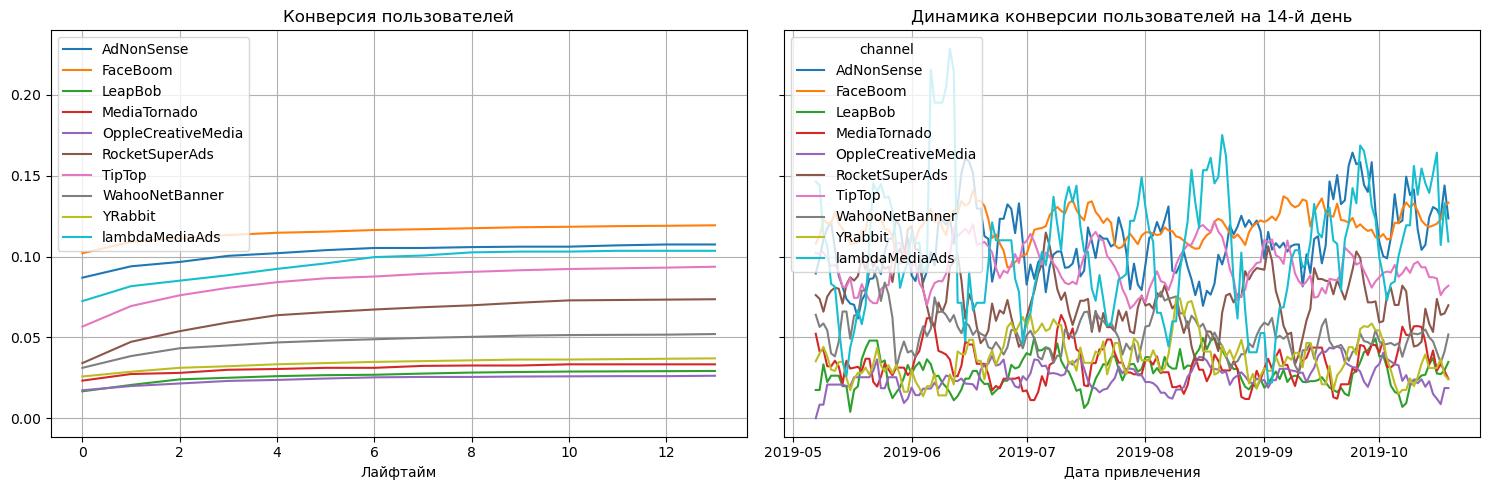

In [32]:
#Проверим конверсию пользователей и динамику её изменения. Построим и изучим графики конверсии.
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:**

Лидером является FaceBoom, аутсайдером OppleCreativeMedia. У lambdaMediaAds конверсия нестабильна, много сильных скачков и сильных падений.

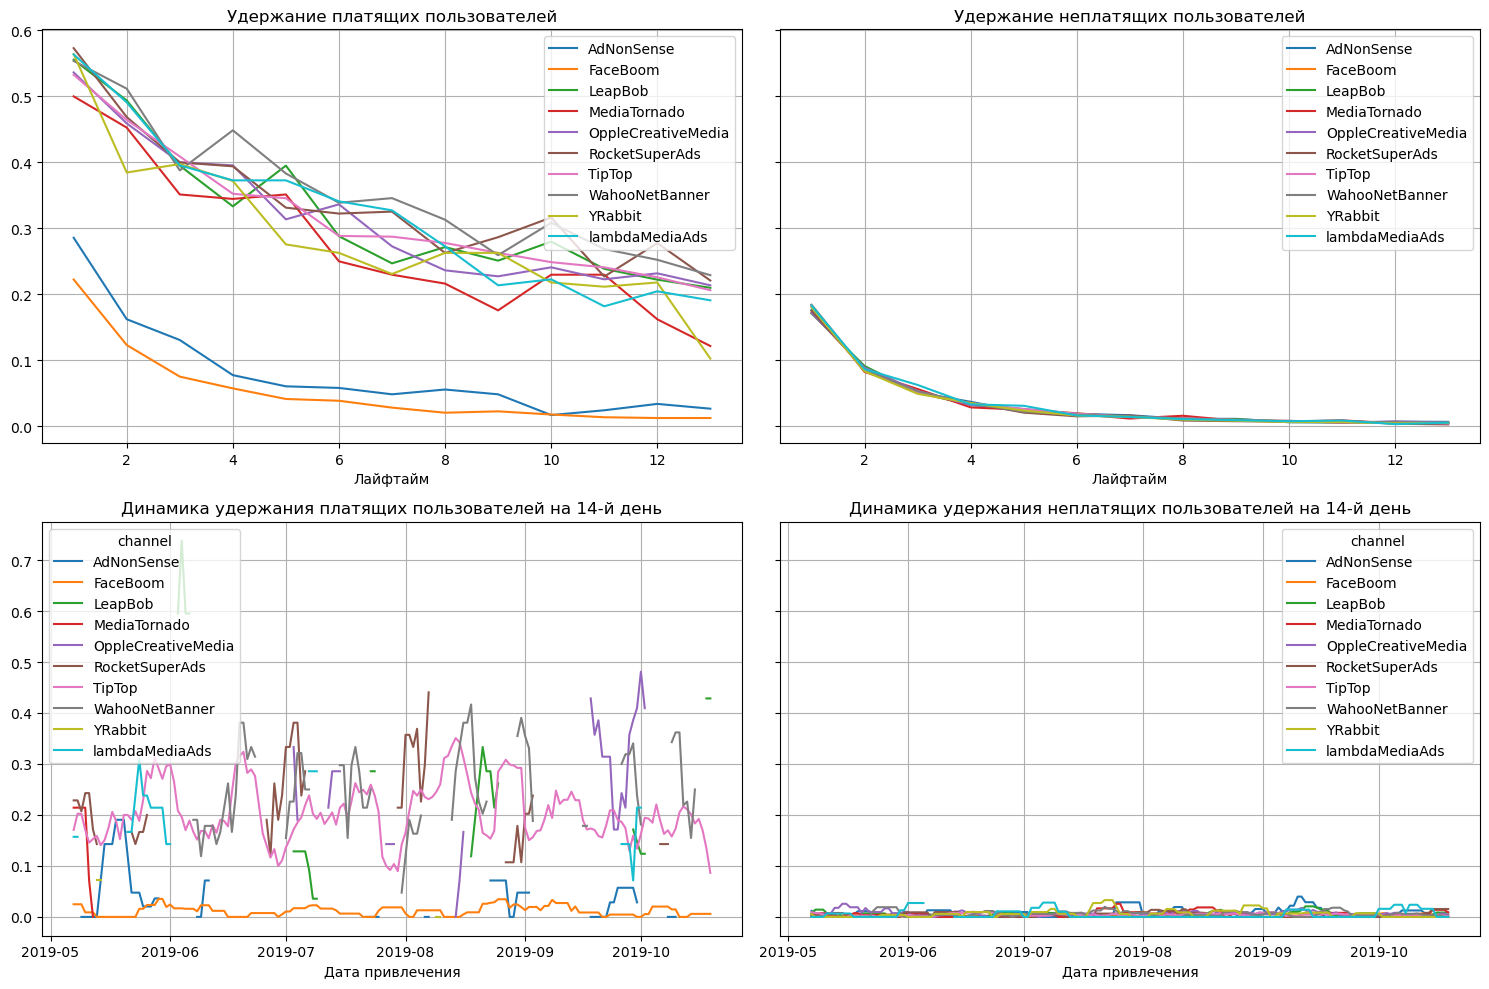

In [33]:
#Проверим конверсию удержания пользователей. Построим и изучим графики удержания.
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_organic, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:**

Удержание пользователей из FaceBoom и AdNonSense гораздо ниже, чем пользователей из других источников. Удержание пользователей TipTop довольно высокое и конверсия выше среднего, возможно этот канал самый дорогой, т.к. и расходы на нем выше чем на других каналах.

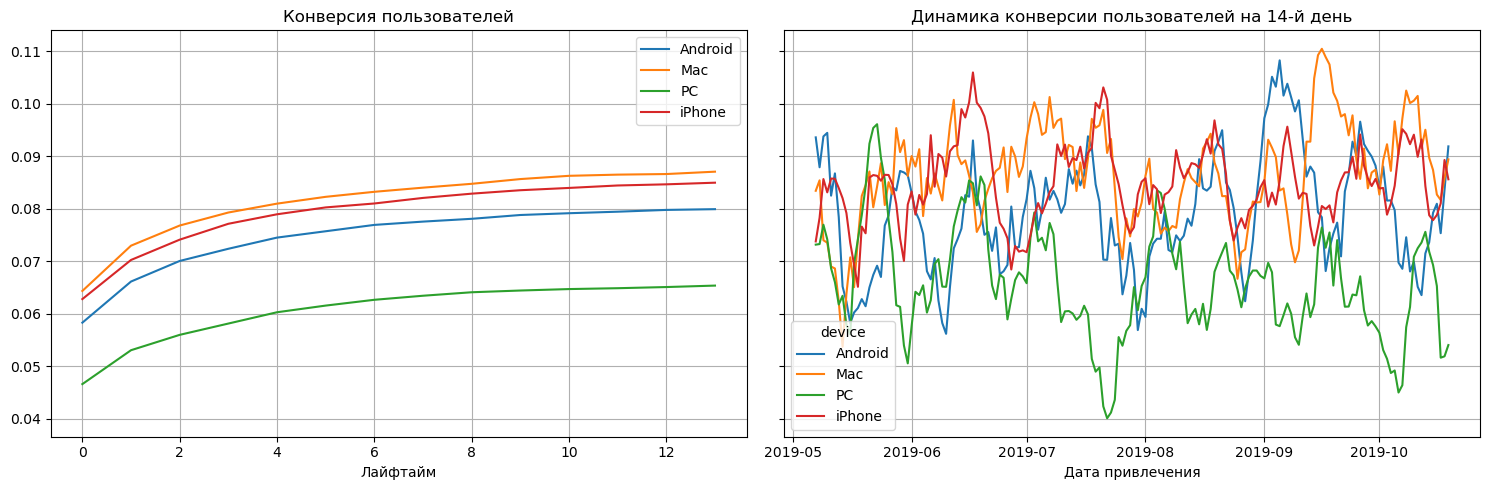

In [34]:
# Конверсия с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:**

Выше конверсия у Мас и IPhone, затем идет Android, аутсайдер РС.

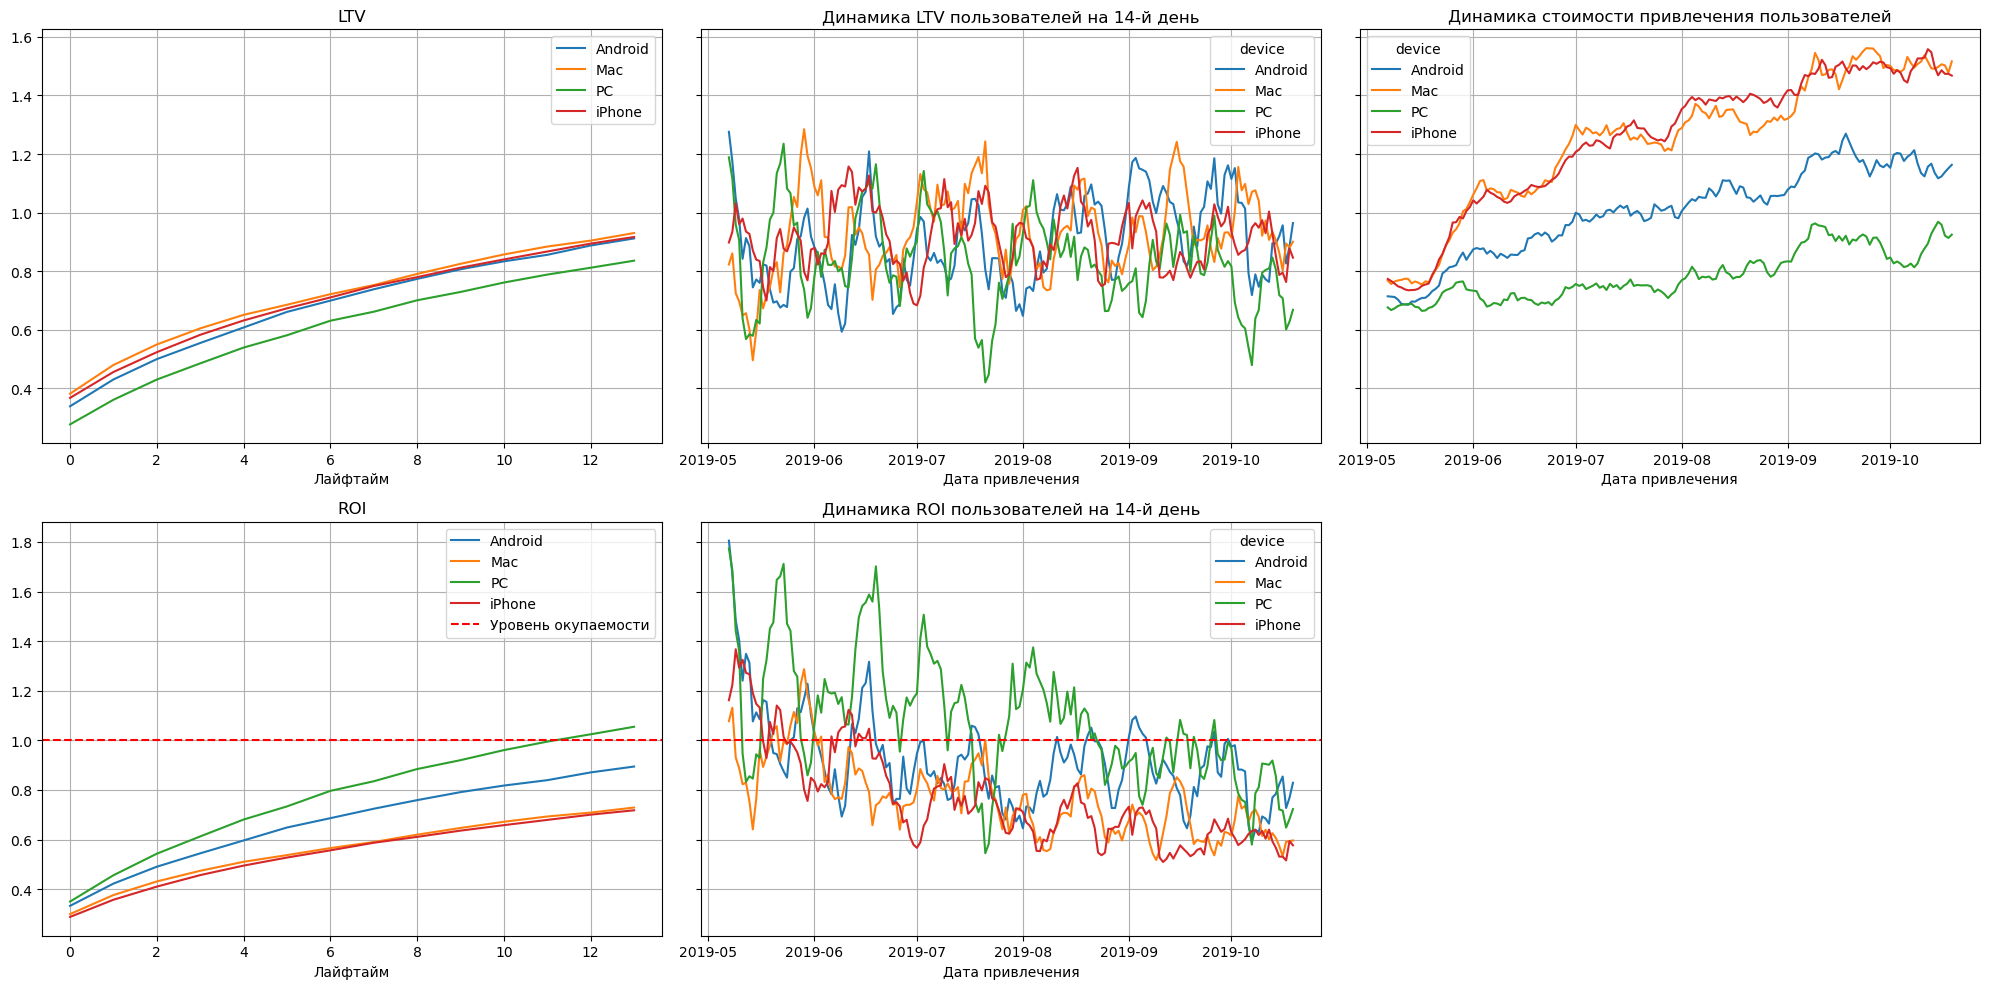

In [35]:
#Проанализируем окупаемость рекламы с разбивкой по устройствам. 
#Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

**Вывод:**

По графикам можно сделать такие выводы:
- Окупаются расходы только для устройств РС.
- CAC растет на всех устройствах.
- LTV стабилен на всех устройствах.

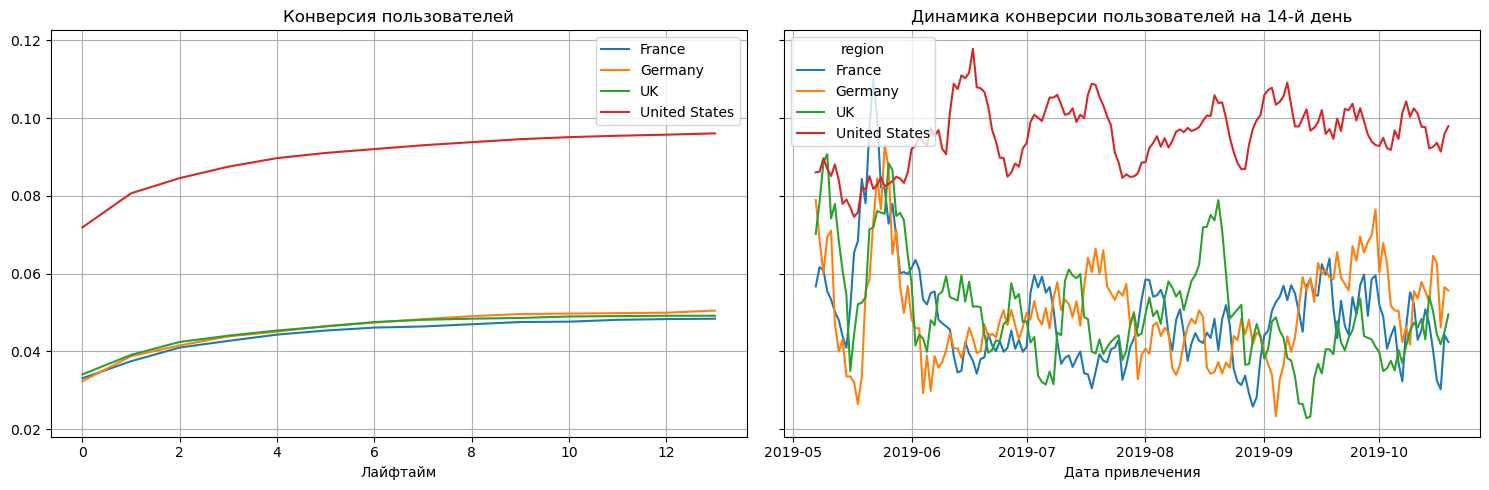

In [36]:
# Конверсия с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод:**

Лидером в данном случае является США, самый большой скачек в динамике в июне, в европейских старнах было несколько скачков, возможно это итоги успешных рекламных компаний.

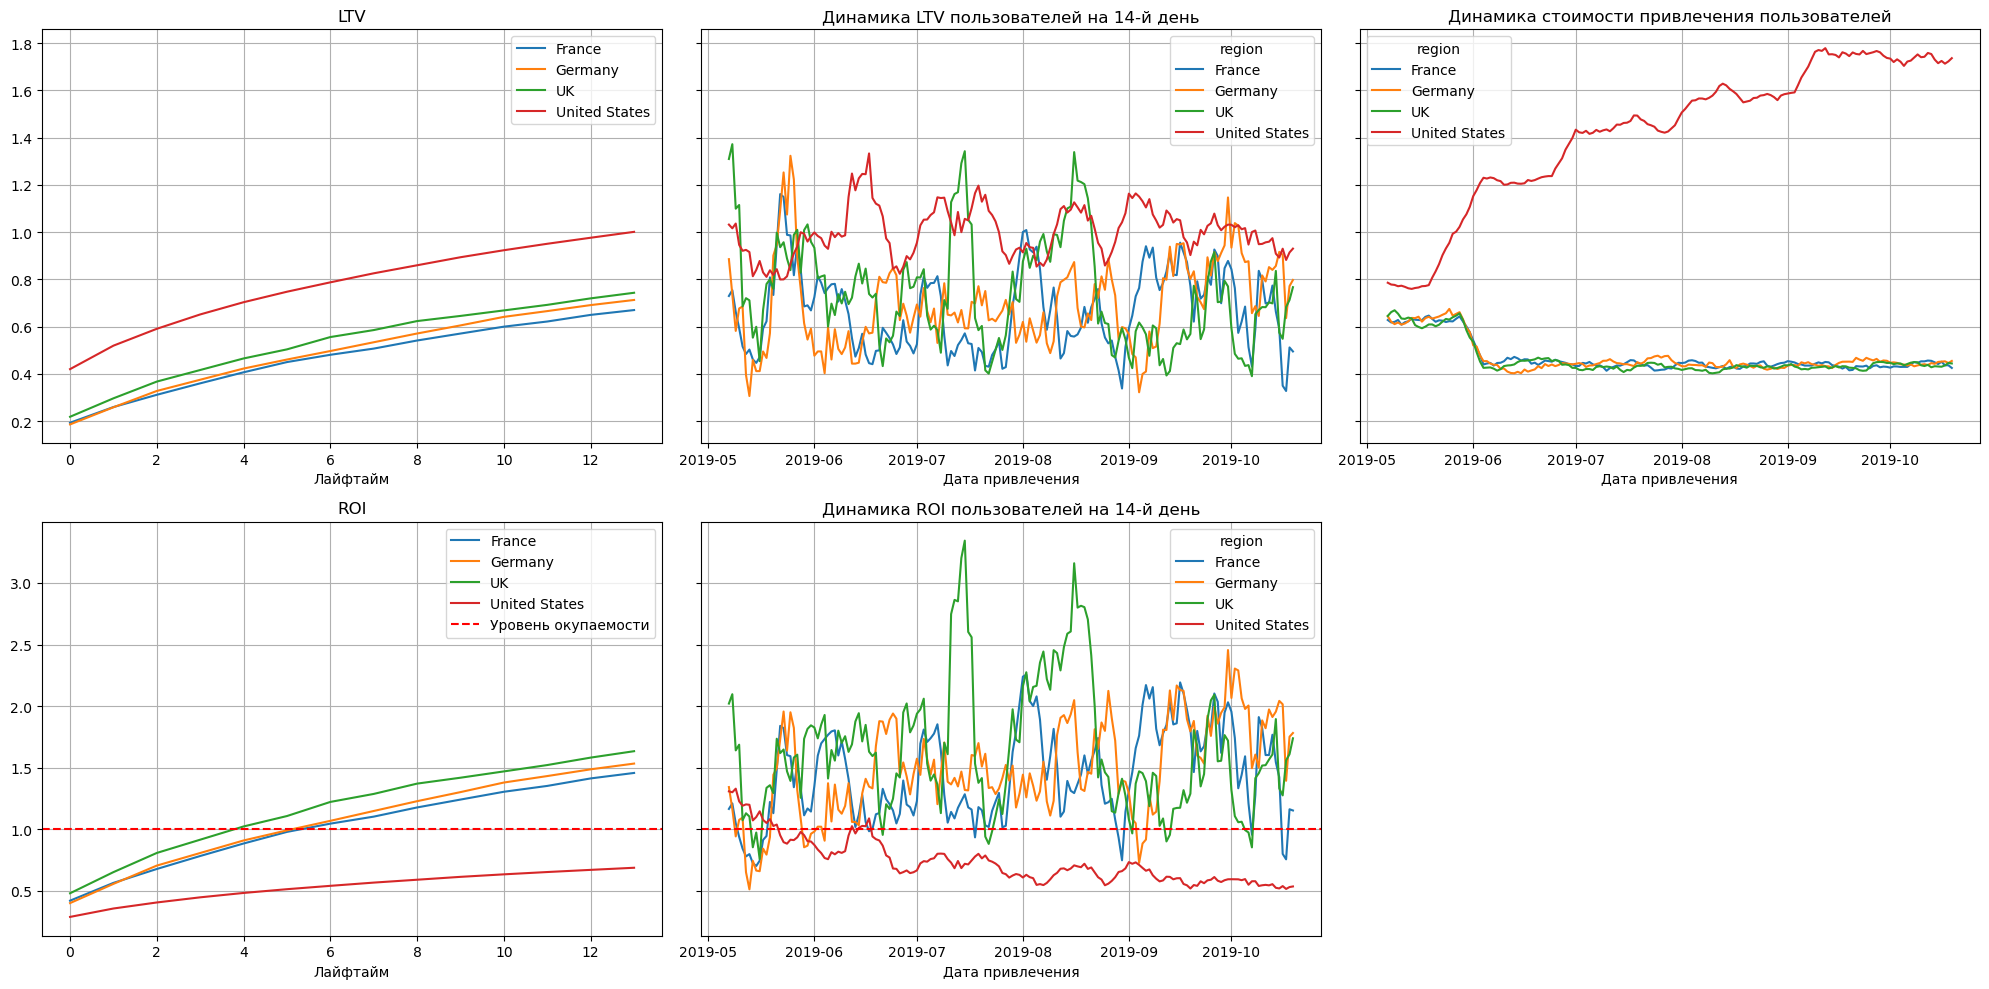

In [37]:
#Проанализируем окупаемость рекламы с разбивкой по странам. 
#Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

**Вывод:**

По графикам можно сделать такие выводы:
- В США реклама не окупается, в отличие от других стран.
- CAC растет в США, в других странах держится низко.
- LTV стабилен везде.

Динамика стоимости в США растет в отличае от Европейский стран, в которых, к концу июня, динамика снизилась и шла равномерно до октября включительно. Динамика окупаемости расходов у США начиная с мая падает, в Англии два скачка в июле и августе, видимо итоги удачных рекламных кампаний. 

Общее количество пользователей приложения и платящих пользователей больше всего в США, которые видимо предпочитают пользоваться устройствами Мас и iPhone, за счет этого, думаю, и связано их лидерство по объему расходов, но не окупаемости.

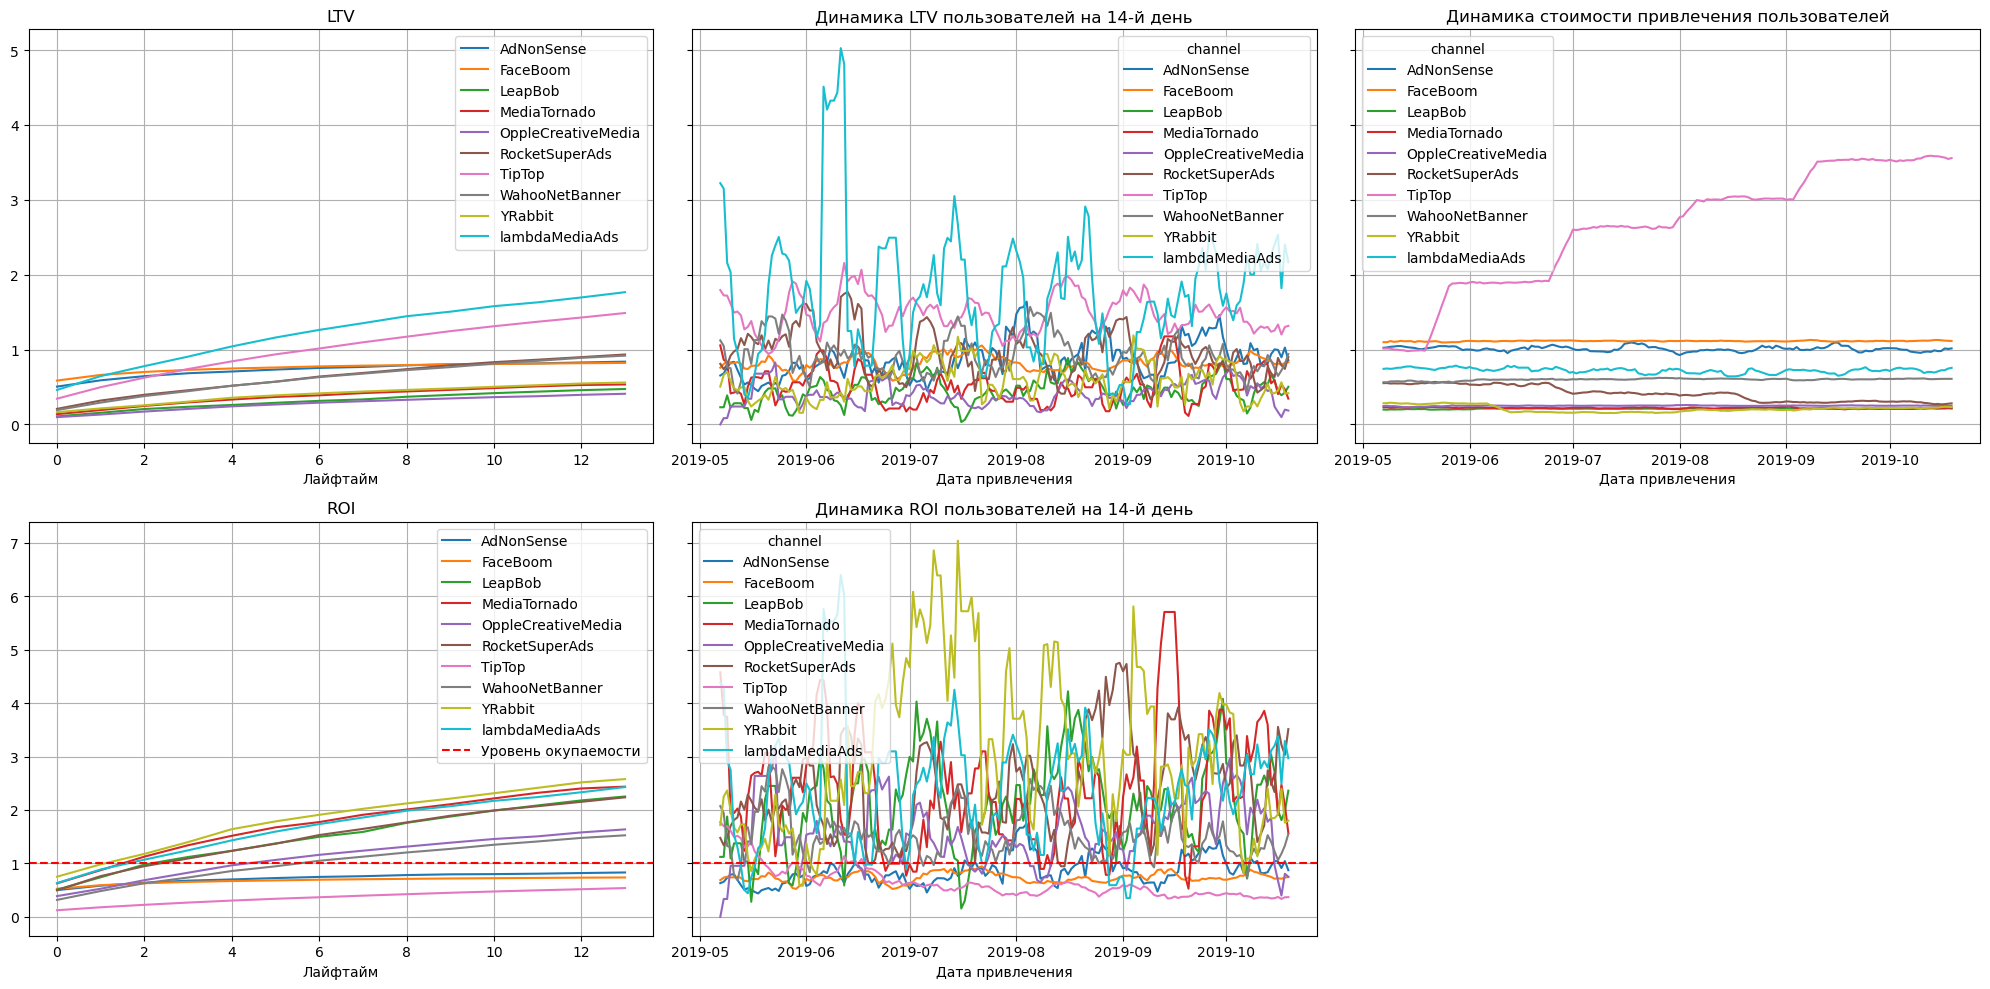

In [38]:
#Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 
#Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

**Вывод:**

По графикам можно сделать такие выводы:
- Во всех каналах, кроме TipTop, FaceBoom и AdNonSense реклама окупается. 
- CAC растет в TipTop, а в остальных держится низко.
- LTV стабилен везде.

Лидером по окупаемости является YRabbit, в динамике окупаемости этот канал также выделяется в отличие от канала TipTop, который является аутсайдером по окупаемости и динамике окупаемости, которая с мая только падает, а затраты только растут. Также можно отметить хорошие показатели у канала lambdaMediaAds, расходы окупаются, и LTV выше остальных каналов.

In [39]:
#Исключим трех лидеров по САС в кампании и "органиков"
profiles2 = profiles.query('channel != "TipTop" and channel != "FaceBoom" and channel != "AdNonSense" and channel != "organic"')

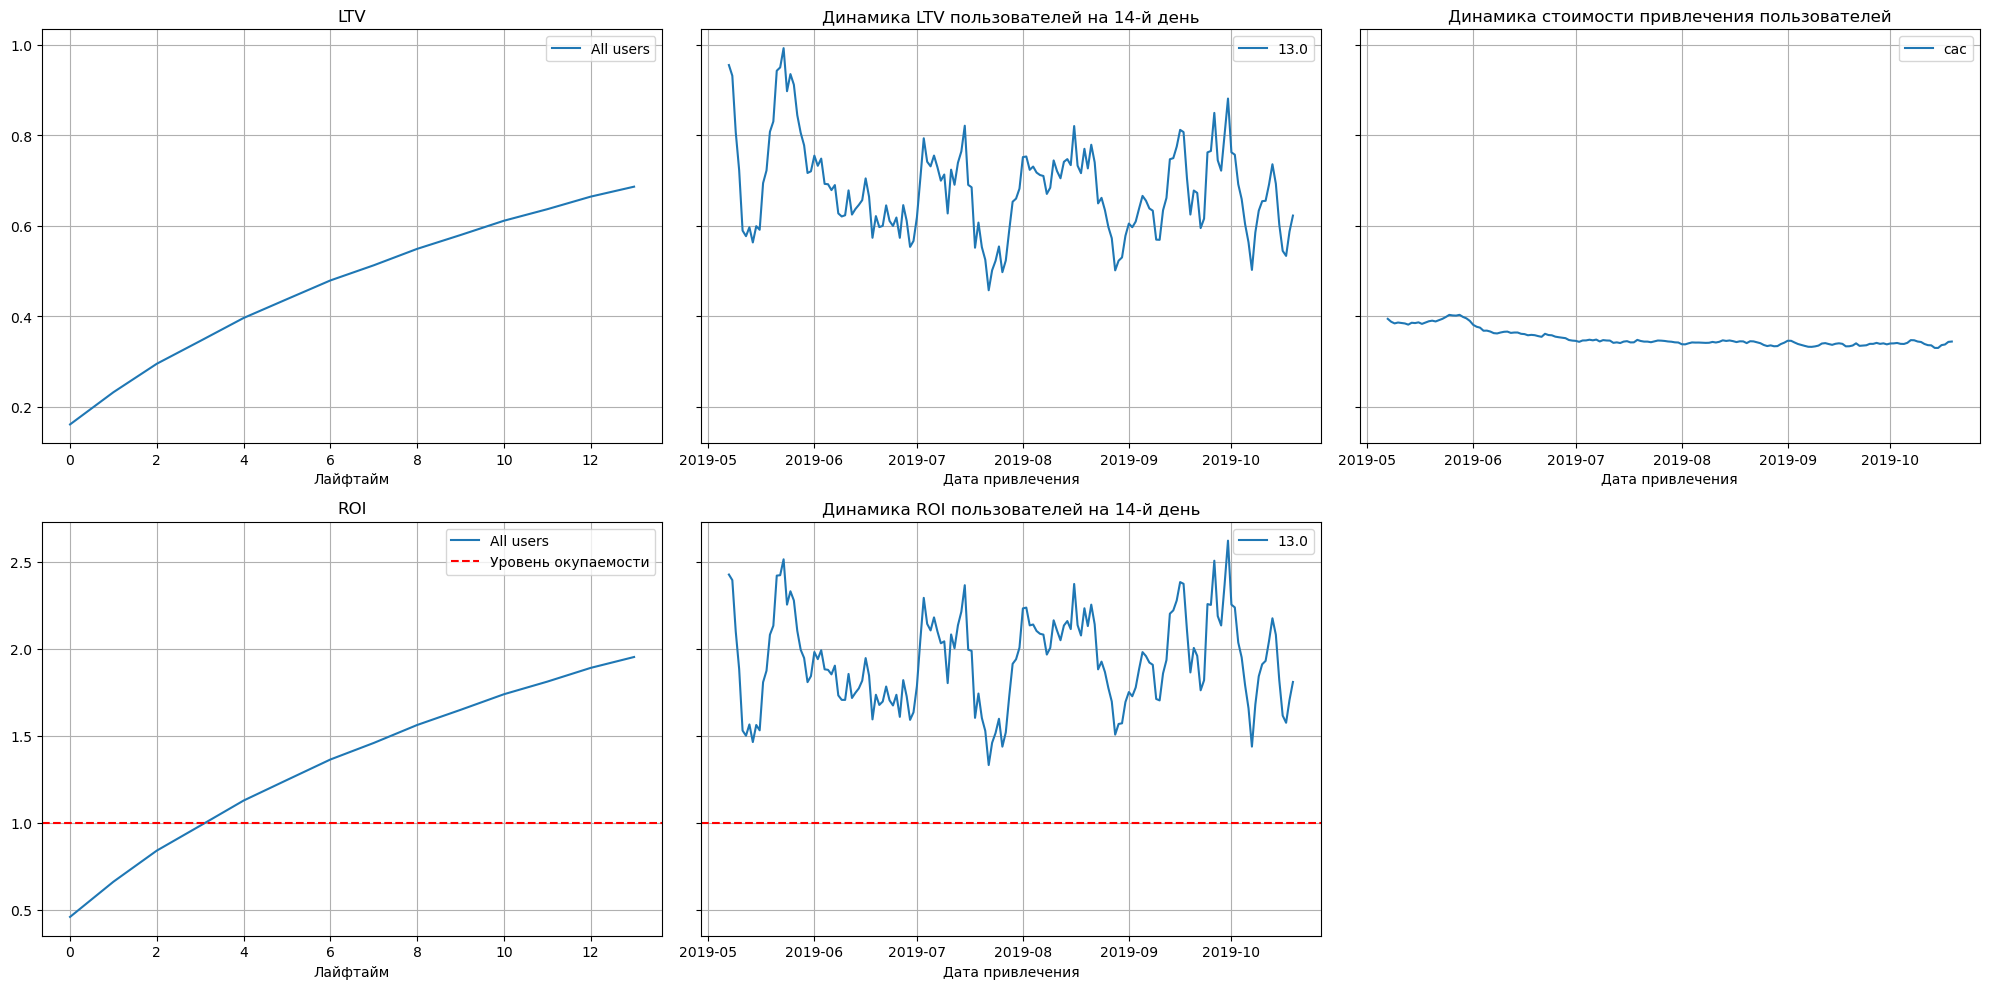

In [40]:
#Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles2, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

In [41]:
#Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 
ad_costs1 = channel_users.merge(costs.groupby('channel')['costs'].sum().reset_index(), on = 'channel', how = 'left')
ad_costs1 = ad_costs.query('channel != "TipTop" and channel != "FaceBoom" and channel != "AdNonSense" and channel != "organic"').copy()

ad_costs1['cac_costs'] = ad_costs.costs / ad_costs.total_users
ad_costs1.sort_values(by='cac_costs', ascending=False)

,channel,total_users,payers,payer_rate,costs,cac_costs
9,lambdaMediaAds,2149,225,10.469986,1557.60,0.724802
7,WahooNetBanner,8553,453,5.296387,5151.00,0.602245
5,RocketSuperAds,4448,352,7.913669,1833.00,0.412095
4,OppleCreativeMedia,8605,233,2.707728,2151.25,0.250000
8,YRabbit,4312,165,3.826531,944.22,0.218975
3,MediaTornado,4364,156,3.574702,954.48,0.218717
2,LeapBob,8553,262,3.063253,1797.60,0.210172


**Вывод:**

Если исключить трех лидеров по САС в кампании и "органиков", то картина по окупаемости очень оптимистична: окупаемость присутствует как к концу 14 дней так и в динамике за 6 месяцев. Расходы же снижаются и не превышают средний САС по всем каналам.

### Выводы

- Реклама, направленная на привлечение пользователей в целом, не окупается.
- Оказывают негативное влияние на окупаемость рекламы: устройства - Мас и iPhone, страны - United States, рекламные каналы - TipTop, FaceBoom, AdNonSense.
- Расходы на рекламу завышенные, не окупаются.
- Снизить расходы или обратить внимание на другие каналы, например lambdaMediaAds и WahooNetBanner.

**Причины неэффективности привлечения пользователей:**
- Расходы на рекламу по устройствам iPhone и Mac завышенные.
- Завышенные расходы на рекламу в стране United States. Хоть конверсия высокая, но окупаемости нет и удержание платящих в этой стране крайне маленькая.
- Крайне завышенные траты на канал TipTop.
- Слабые показатели удержания у канала AdNonSense и FaceBoom.

**Рекомендации для отдела маркетинга:**
- Снизить расходы на рекламу в США до уровня других стран.
- Снизить расходы на каналы TipTop, AdNonSense и FaceBoom до уровня 0,5, изменив модель оплаты на более дешевую.
- Обратить внимание на другие каналы например lambdaMediaAds и WahooNetBanner.